In [44]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np
from torchsummary import summary

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(figsize=(7,7))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [46]:
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5,],
        std=[0.5]
    )
])

data = MNIST('', train=True, download=True, transform=transform)

In [47]:
len(data)

60000

# WGAN-GP

## Generator

In [48]:
class Generator(nn.Module):
    def __init__(self, z_dim=64):
        super(Generator, self).__init__()    
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, (3,3), 2, 0), # 3x3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, (4,4), 1, 0), # 6x6
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, (3,3), 2, 0), # 13x13
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 1, (4,4), 2, 0), # 28x28
            nn.Tanh()
        )
        
    def forward(self, noise):
        out = self.net(noise.view(-1, self.z_dim, 1, 1))
        return out

## Critic

In [49]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(1, 16, (4,4), 2, 0),  # 13x13
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2, True),
        
        nn.Conv2d(16, 32, (4,4), 2, 0), # 5x5
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, True),
        
        nn.Conv2d(32, 1, (4,4), 2, 0),  # 1x1
        )
        
    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 1)

## Gradient Penalty

In [50]:
def get_gradient(critic, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = critic(mixed_images)
    gradient = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=mixed_images,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = torch.norm(gradient, dim=1)
    penalty = torch.mean(gradient_norm - 1)**2
    return penalty

## W-Loss

In [51]:
def gen_loss(y_pred_fakes):
    loss = - torch.mean(y_pred_fakes)
    return loss

def critic_loss(y_pred_real, y_pred_fake, gp, c_lambda):
    loss = y_pred_fake.mean() - y_pred_real.mean() + (c_lambda * gp)
    return loss

## Training Loop

In [52]:
# custom weights initialization called on gen and disc model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)    

In [53]:
z_dim = 64

generator = Generator().to(device)
generator.apply(weights_init)
critic = Critic().to(device)
critic.apply(weights_init)

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
c_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))

dataloader = DataLoader(data, batch_size=128, shuffle=True, drop_last=True, )

In [54]:
def train(
    generator, 
    critic,
    z_dim,
    data,
    g_optimizer,
    c_optimizer,
    gen_loss,
    crit_loss,
    c_lambda,
    get_gradient,
    gradient_penalty,
    crit_iterations,
    device,
    epochs=1):
    
    g_epoch_losses = []
    c_epoch_losses = []
    
    for epoch in tqdm(range(epochs)):
        
        generator = generator.train()
        g_batch_losses = []
        c_batch_losses = []
        
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.shape[0]
            
            ########################################
            ### Start Critic Training
            ########################################
            
            crit_iter_losses = 0
            for _ in range(crit_iterations):
                # Create noise
                noise = torch.randn(batch_size, z_dim, device=device)
                # generate fake images, no grad
                fake_images = generator(noise).detach()
                # forward prop. of reals and fakes through critic
                y_pred_real = critic(real_images)
                y_pred_fake = critic(fake_images.detach())
                # Calculate the gradient penalty
                epsilon = torch.rand(batch_size, 1, 1, 1, requires_grad=True, device=device)
                gradient = get_gradient(critic, real_images, fake_images, epsilon)
                gp = gradient_penalty(gradient)
                # Calculate the critic loss for this critic iteration
                crit_loss = critic_loss(y_pred_real, y_pred_fake, gp, c_lambda)
                # Append to critic losses
                crit_iter_losses += crit_loss
                
            # Calculate the mean critic loss for overall iterations
            c_loss = crit_iter_losses / crit_iterations
            # Grads & backprop. critic only.
            c_optimizer.zero_grad()
            c_loss.backward()
            c_optimizer.step()
            
            c_batch_losses.append(c_loss.cpu().item())
            
            ########################################
            ### End Critic Training
            ########################################
            
            
            ########################################
            ### Start Generator Training
            ########################################
            
            # Create noise
            noise = torch.randn(batch_size, z_dim, device=device)
            
            # Generate fake images with grad enabled
            fake_images = generator(noise)
            
            # Forward prop. of critic
            y_pred_fake = critic(fake_images)
            
            # Calculate generator loss with grad enabled
            g_loss = gen_loss(y_pred_fake)
            # Backprop. generator only
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            g_batch_losses.append(g_loss.cpu().item())
            
            ########################################
            ### End Generator training
            ########################################
        
        g_epoch_losses.append(np.sum(g_batch_losses) / batch_size)
        c_epoch_losses.append(np.sum(c_batch_losses) / batch_size)
        
        print("Epoch: {}  c_loss: {:.4f}  g_loss: {:.4f}"
              .format(epoch, c_epoch_losses[-1], g_epoch_losses[-1]))
        
        generator = generator.eval()
        images = generator(torch.randn(25,z_dim, device=device)).cpu()
        show_tensor_images(images)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 0  c_loss: 1.3479  g_loss: -5.1861


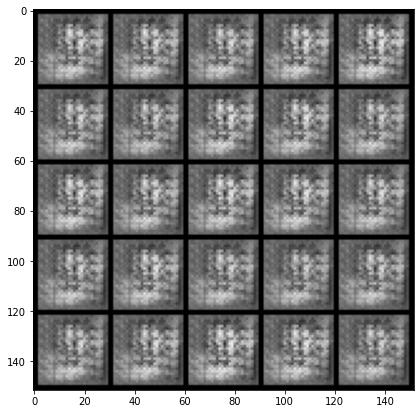

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 1  c_loss: -2.8907  g_loss: -4.4150


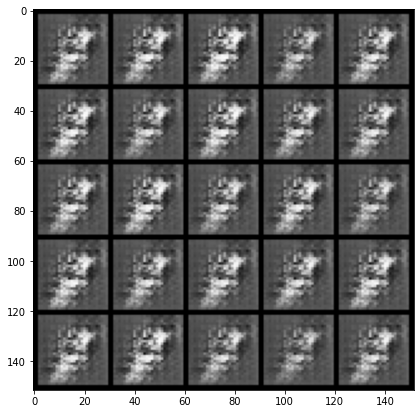

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 2  c_loss: -1.7266  g_loss: -3.5410


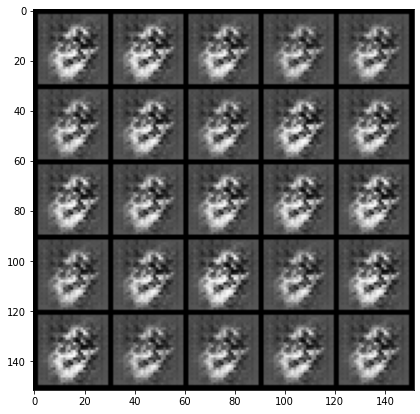

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 3  c_loss: -3.1447  g_loss: -1.3512


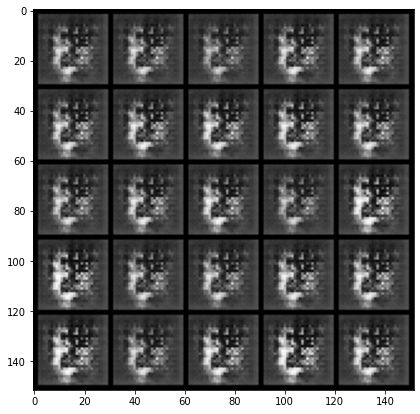

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 4  c_loss: -2.7725  g_loss: -1.0749


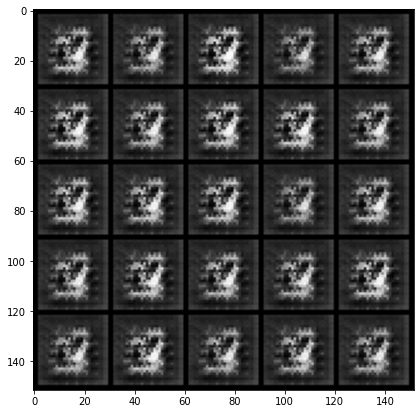

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 5  c_loss: -2.5559  g_loss: -1.9559


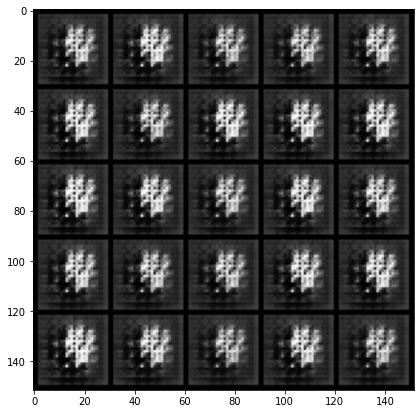

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 6  c_loss: -4.0432  g_loss: -1.8568


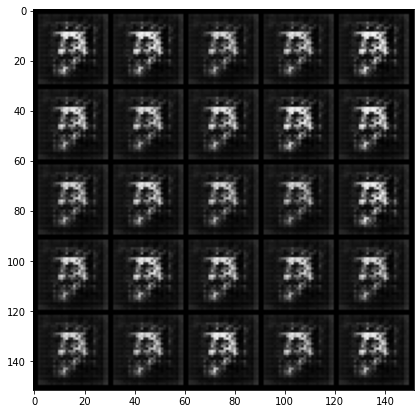

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 7  c_loss: -4.3617  g_loss: -2.8975


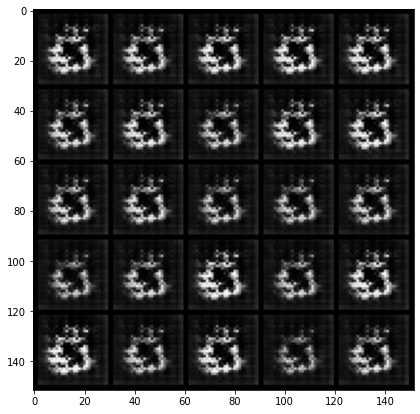

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 8  c_loss: -5.4348  g_loss: -2.7013


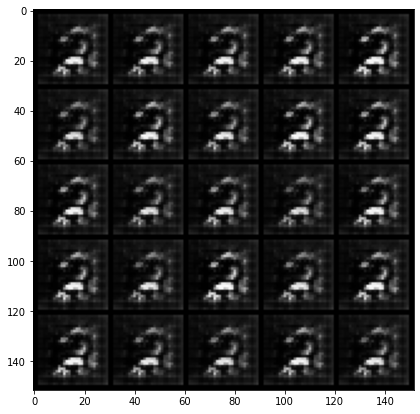

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 9  c_loss: -6.0553  g_loss: -4.2323


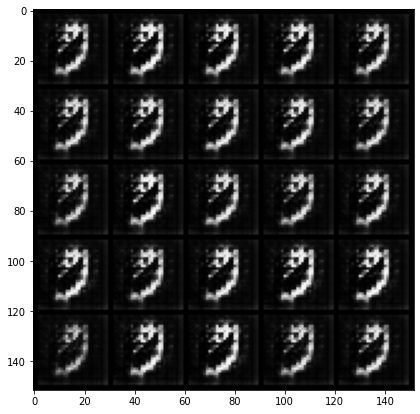

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 10  c_loss: -4.4202  g_loss: -4.2962


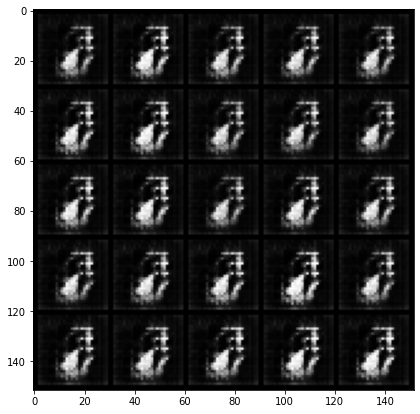

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 11  c_loss: -5.3740  g_loss: -5.0946


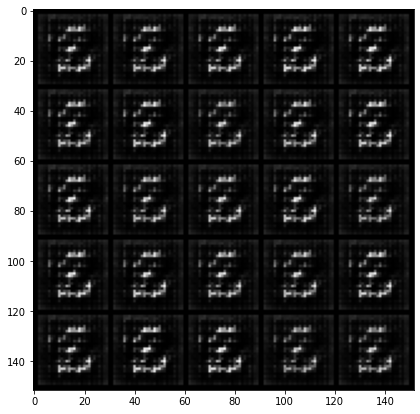

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 12  c_loss: -5.7172  g_loss: -2.7386


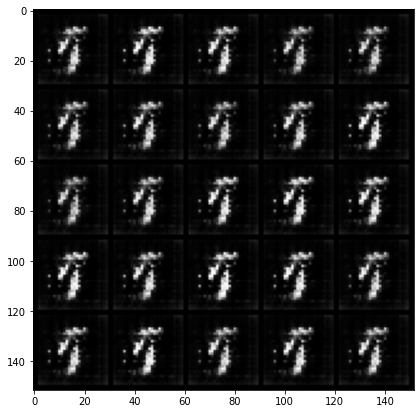

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 13  c_loss: -7.9238  g_loss: -4.5564


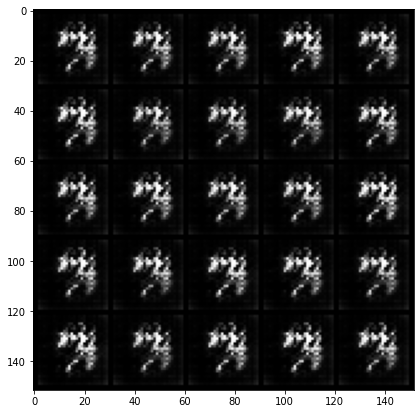

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 14  c_loss: -7.7557  g_loss: -0.9404


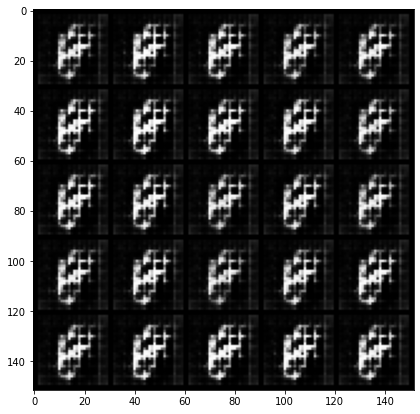

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 15  c_loss: -5.7313  g_loss: -2.4036


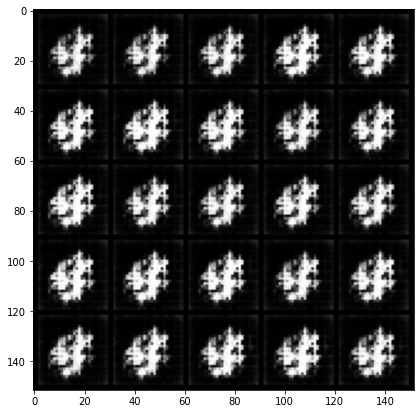

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 16  c_loss: -6.2222  g_loss: -4.6109


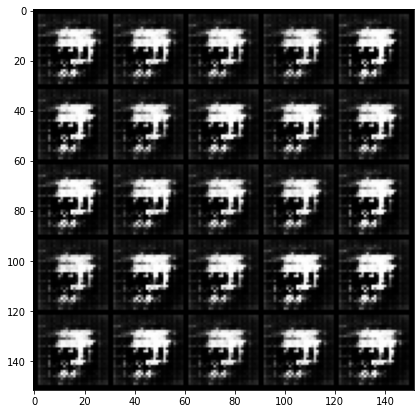

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 17  c_loss: -4.4746  g_loss: -5.4559


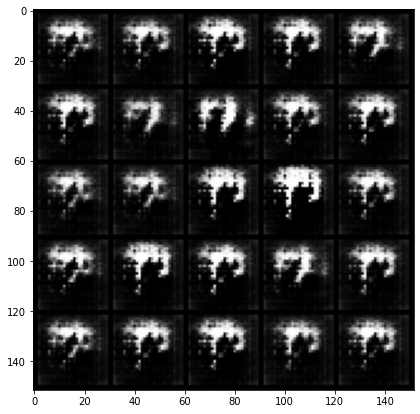

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 18  c_loss: -3.3145  g_loss: -6.1444


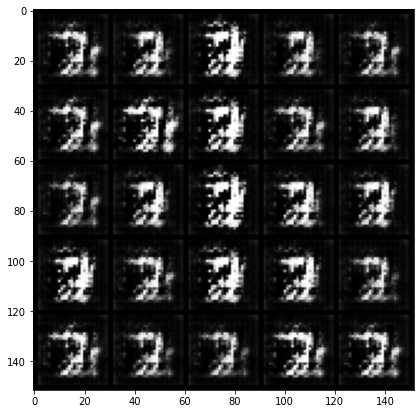

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 19  c_loss: -1.8525  g_loss: -8.2220


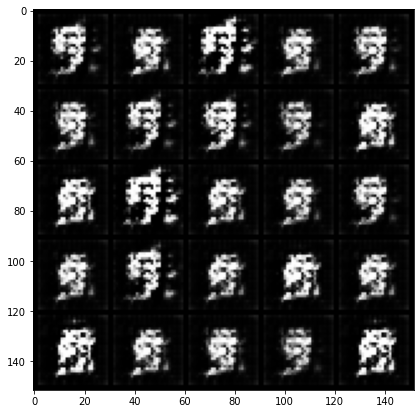

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 20  c_loss: -2.0851  g_loss: -6.0950


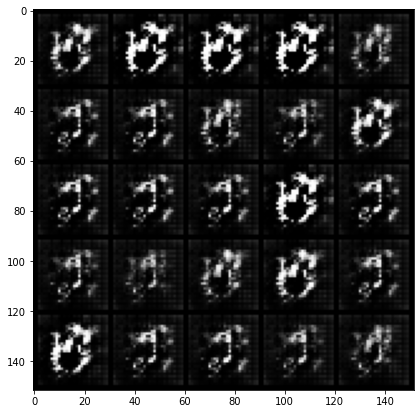

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 21  c_loss: -4.0457  g_loss: -4.1849


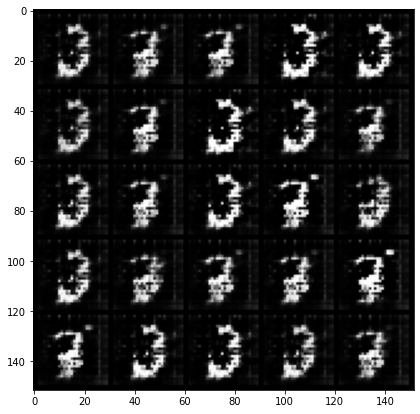

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 22  c_loss: -2.9437  g_loss: -8.7111


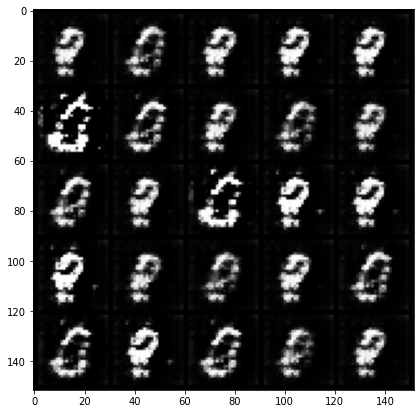

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 23  c_loss: -3.6644  g_loss: -6.2381


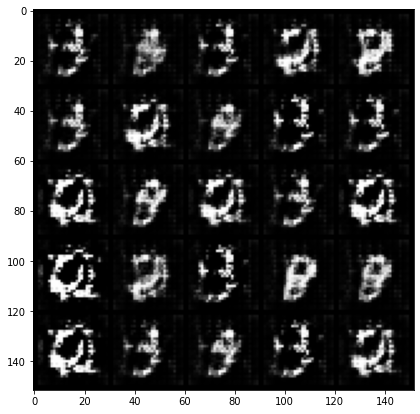

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 24  c_loss: -3.1677  g_loss: -7.0410


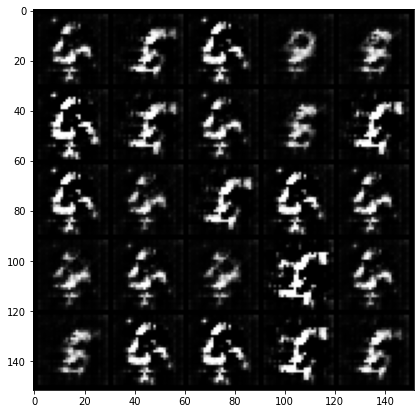

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 25  c_loss: -3.8086  g_loss: -6.8869


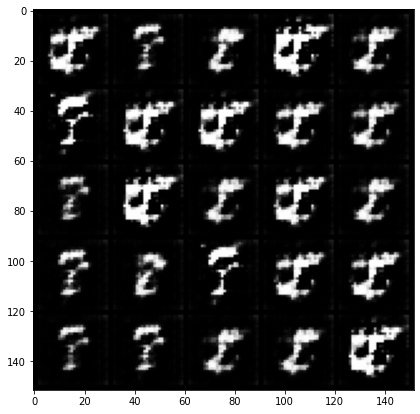

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 26  c_loss: -5.4301  g_loss: -8.2728


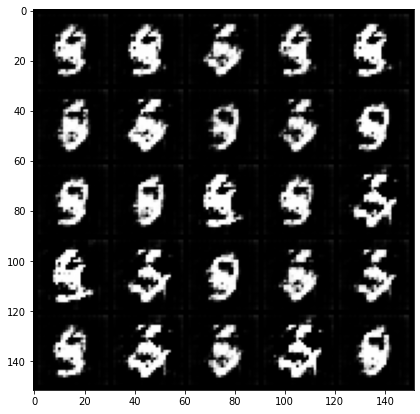

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 27  c_loss: -4.7280  g_loss: -6.0395


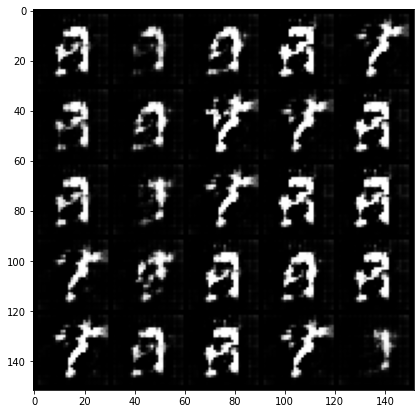

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 28  c_loss: -5.6071  g_loss: -7.5008


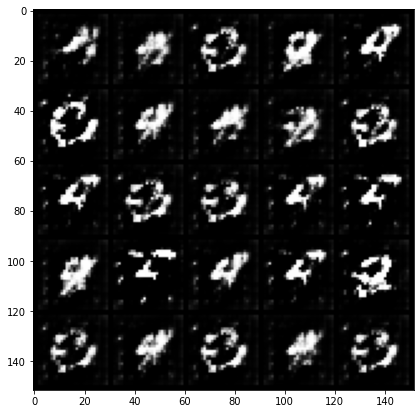

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 29  c_loss: -4.3151  g_loss: -7.2945


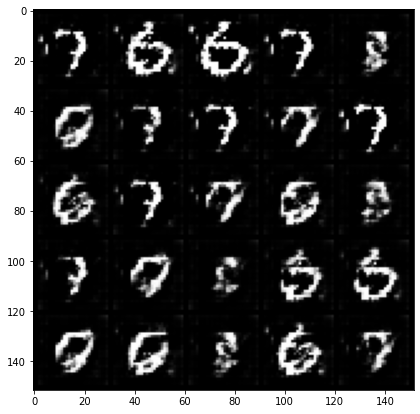

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 30  c_loss: -2.9731  g_loss: -8.0079


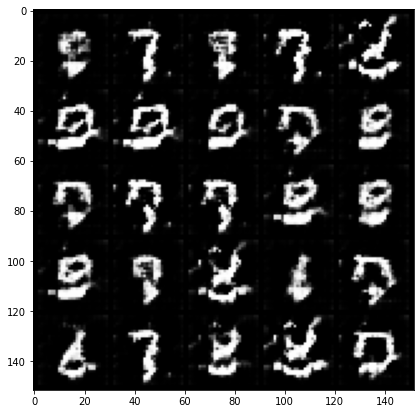

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 31  c_loss: -2.8758  g_loss: -9.2058


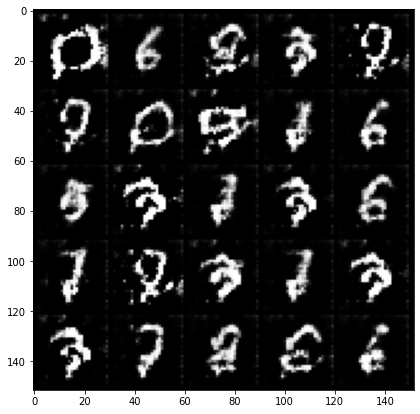

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 32  c_loss: -1.6606  g_loss: -10.3462


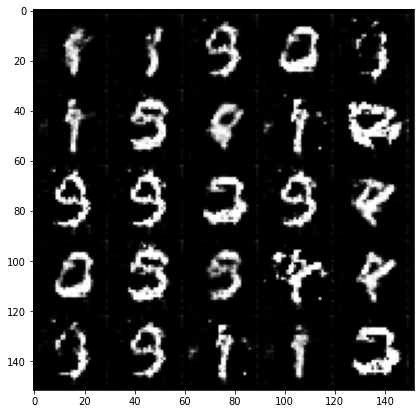

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 33  c_loss: -1.1368  g_loss: -7.5845


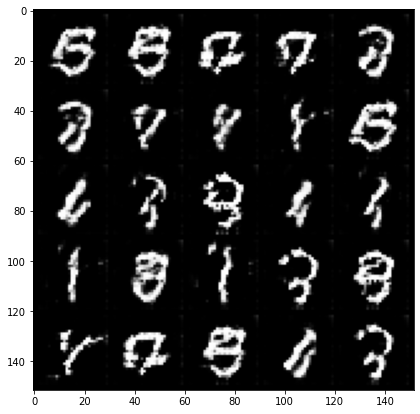

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 34  c_loss: -1.9393  g_loss: -7.8581


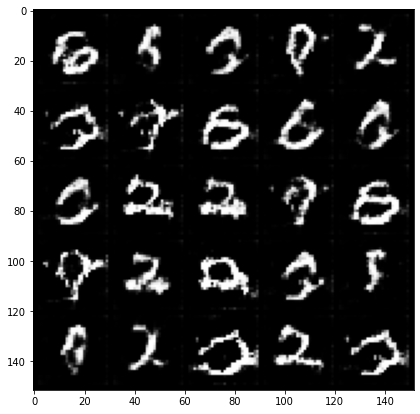

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 35  c_loss: -1.3582  g_loss: -5.5471


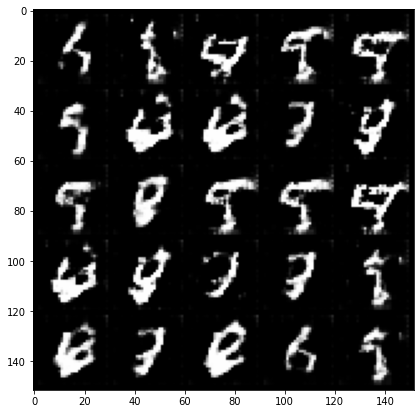

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 36  c_loss: -1.9344  g_loss: -6.9543


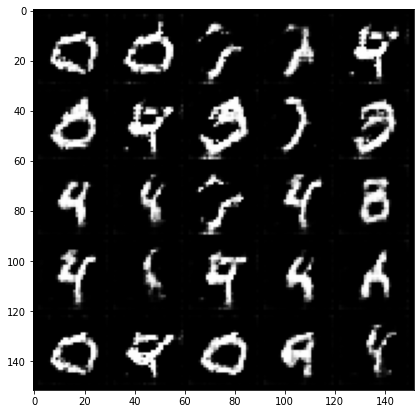

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 37  c_loss: -1.7029  g_loss: -6.5037


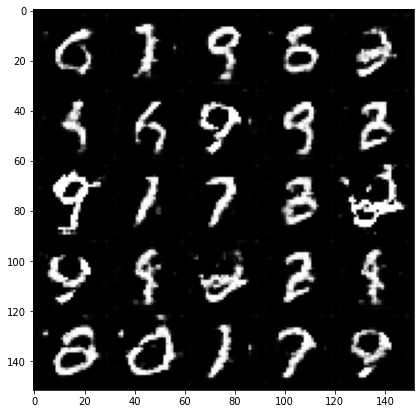

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 38  c_loss: -1.4744  g_loss: -7.7730


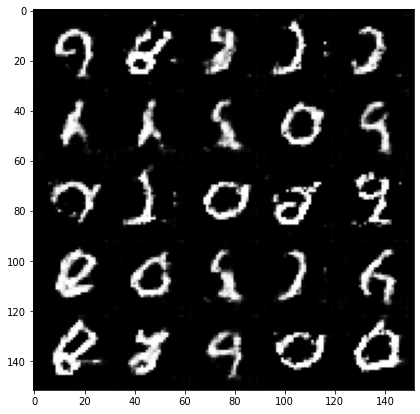

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 39  c_loss: -1.3807  g_loss: -6.2587


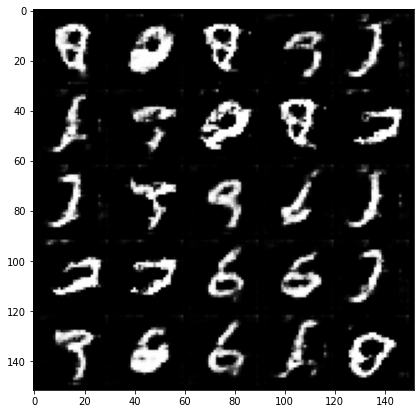

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 40  c_loss: -0.8930  g_loss: -5.4223


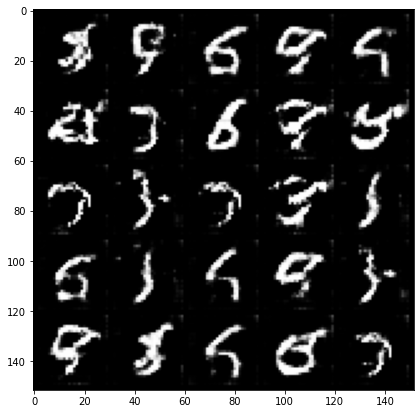

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 41  c_loss: -1.2009  g_loss: -5.1600


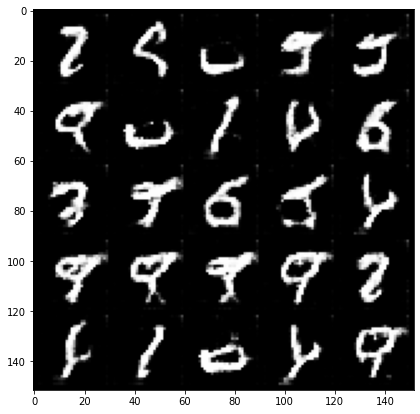

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 42  c_loss: -1.0609  g_loss: -6.8829


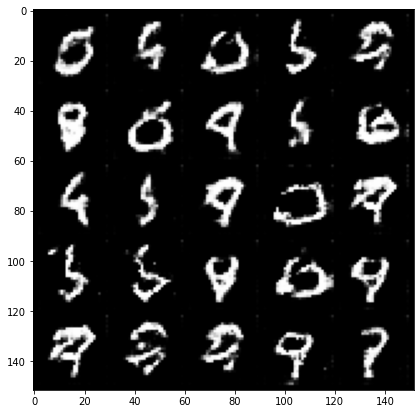

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 43  c_loss: -1.1771  g_loss: -6.8583


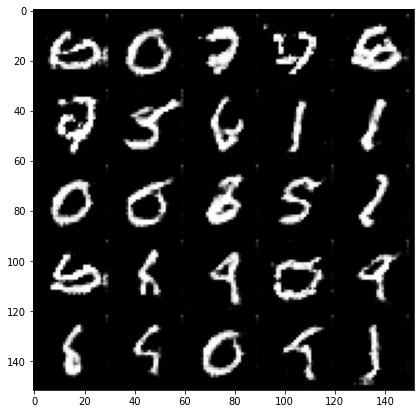

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 44  c_loss: -1.1283  g_loss: -4.9030


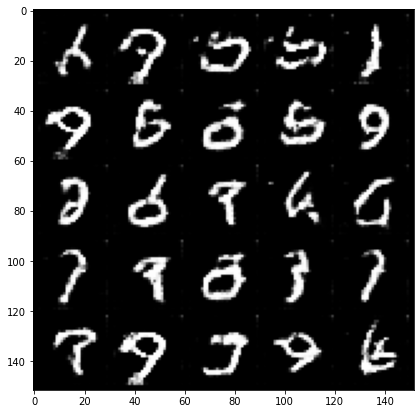

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 45  c_loss: -0.9964  g_loss: -3.3970


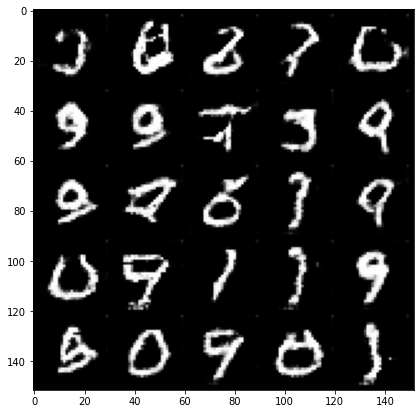

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 46  c_loss: -0.7853  g_loss: -1.6195


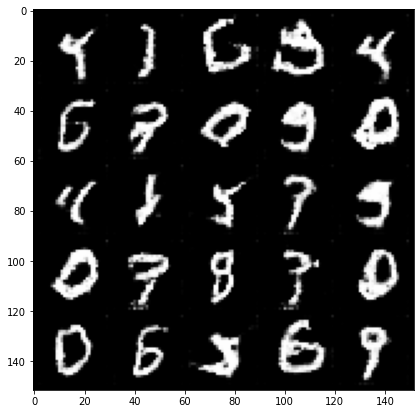

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 47  c_loss: -0.5323  g_loss: -0.4529


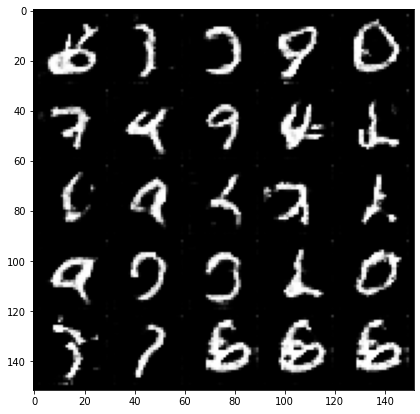

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 48  c_loss: -0.6810  g_loss: 1.3958


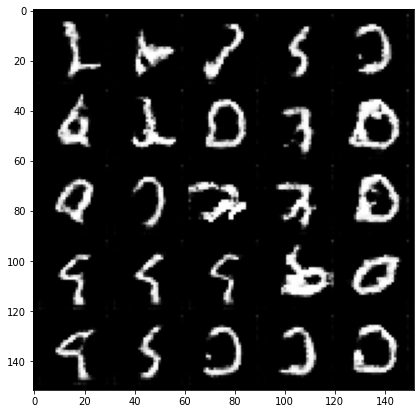

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 49  c_loss: -0.6841  g_loss: 2.1330


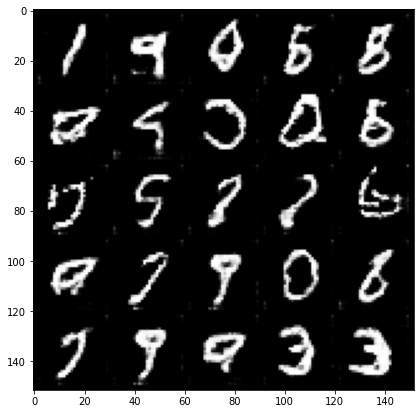

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 50  c_loss: -0.6917  g_loss: 2.8118


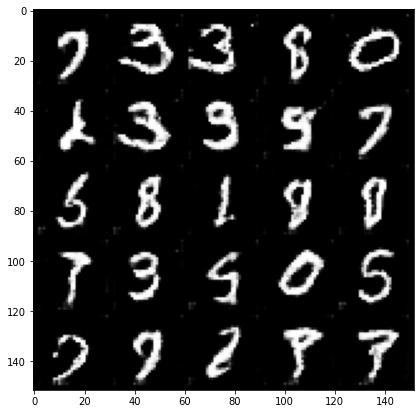

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 51  c_loss: -0.5237  g_loss: 2.8263


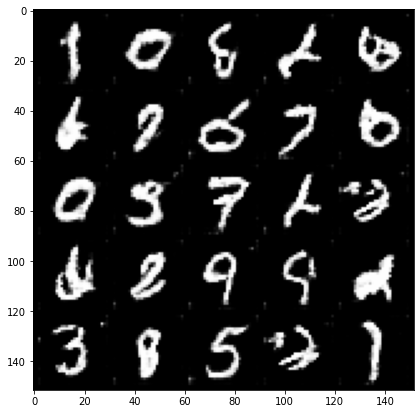

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 52  c_loss: -0.5092  g_loss: 3.2652


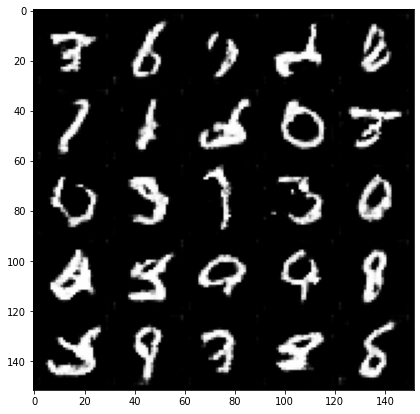

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 53  c_loss: -0.2944  g_loss: 3.6103


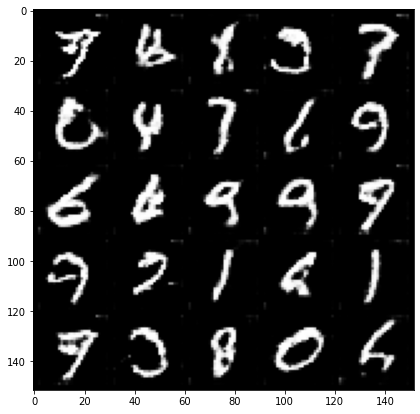

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 54  c_loss: -0.3137  g_loss: 4.0072


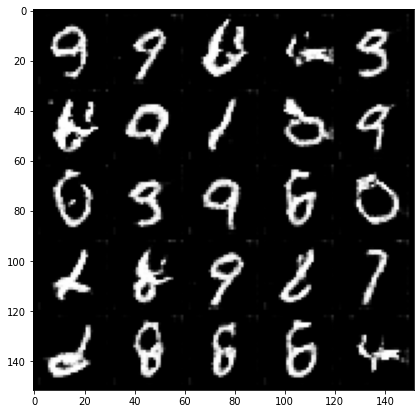

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 55  c_loss: -0.3020  g_loss: 4.1722


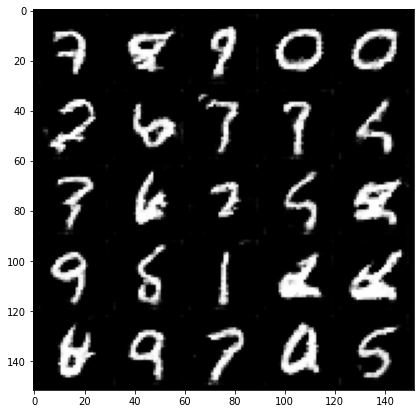

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 56  c_loss: -0.1912  g_loss: 5.2471


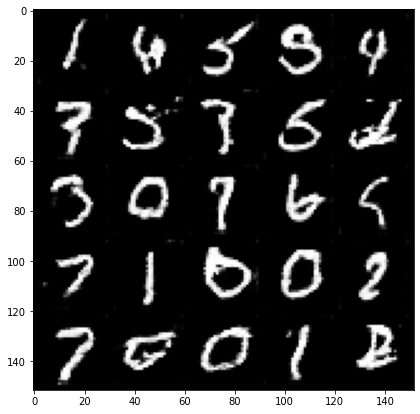

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 57  c_loss: -0.1358  g_loss: 5.8809


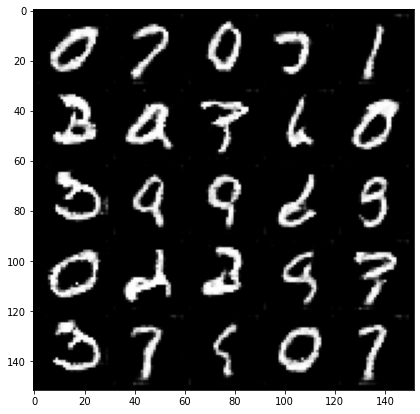

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 58  c_loss: -0.1095  g_loss: 6.4928


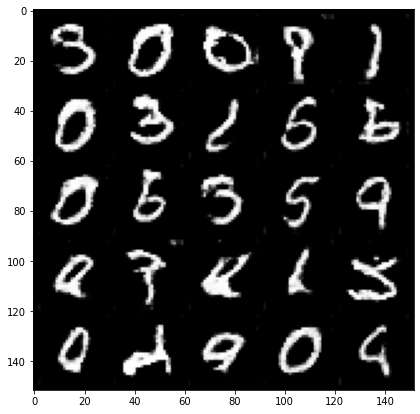

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 59  c_loss: -0.0383  g_loss: 6.9084


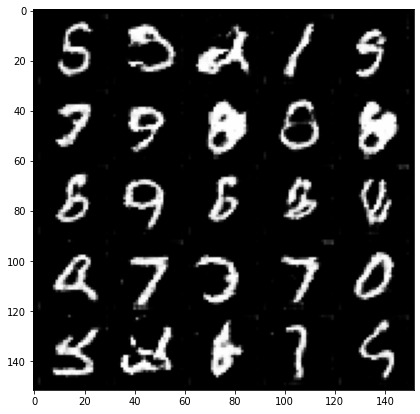

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 60  c_loss: 0.0159  g_loss: 6.6103


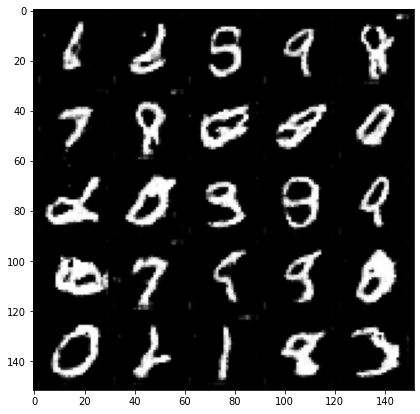

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 61  c_loss: -0.0097  g_loss: 5.9452


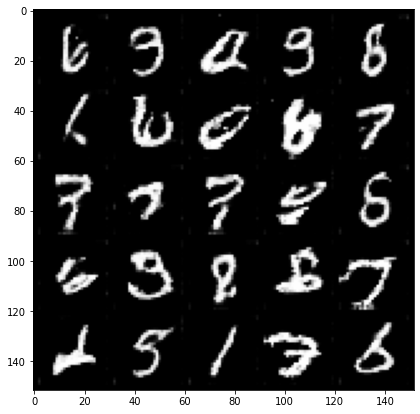

  0%|          | 0/468 [00:00<?, ?it/s]

In [ ]:
train(generator, critic, 64, dataloader, g_optimizer, c_optimizer, gen_loss, critic_loss, 
      crit_iterations=5, 
      c_lambda=10,
      get_gradient=get_gradient,
      gradient_penalty=gradient_penalty,
      device=device,
      epochs=100
     )

In [15]:
for real, _ in dataloader:
    real = real.to(device)
    print(real.device)
    break

cuda:0
